# CLASIFICADOR CLFx

En este notebook se recoge el codigo relativo a un clasificador elemental del `Ensemble` que constituye un clasificador individual del capitulo de diseño del algoritmo predictivo para la longitud del intestino con Support Vector Machines (SVM) Cuántico.

El clasificador global diseñado es un `Ensemble` de pequeños clasificadores que se entrenan con un conjunto de datos de entrenamiento parcial. El codigo de cada clasificador se recoge en diferentes notebooks como este, denominados `clfx.ipynb` (siendo `x` el numero del clasificador). Y en ellos se describe un procedimiento de búsqueda heurística de un kernel optimo de clasificación para el problema de prediccion de la longitud del intestino utilizando las librerías QuASK como se describio en el caipítulo [REF cap kernel cuantico]. 

El proceso de búsqueda se realiza en base a una funcion de coste que evalua el desempeño del clasificador. En este trabajo se desarrolla un evaluador que calcula las métricas de clasificacion del Kernel cuantico cuando se hace una prediccion sobre los datos de entrenamiento. De manera que para el proceso de optimización del Kernel, no vamos a evaluar características del circuito cuantico, ni de expresabilidad, ni del operador de mapeo de características, como hacen los evaluadores propuestos en QuASK, sino que vamos a evaluar el propio desempeño predictivo del Kernel.

Cada clasificador genera unas matrices Gram de Kernel que se almacenan como ficheros y se cargan posteriormente en este notebook para entrenar y predecir con los clasificadores elementales. Finalmente el clasificador global se construye como una combinacion ponderada de los clasificadores elementales que permite maximizar la calidad del clasificador final.


El codigo elaborado permite la realización de una serie de tablas y figuras que describen el proceso de diseño de un clasificador elemental y la evaluacion de las métricas de prediccion que se obtienen.

El código se ha desarrollado en python 3.10 y adicionalmente se utilizan las librerías de numpy, pandas, matplotLib para la realizacion de calculos, tratamiento de datos y visualizacion. Se utilizan tambien las librerías Scikit-Learn para las operaciones de Aprendizaje Máquina (Machine Learning) relativas al algoritmo SVM. Se utilizan las librerías QuASK para el mecanismo de búsqueda heurística del Kernel óptimo. Necesitaremos adicionalmente las librerías `mushroom-rl` que es una dependencia de los optimizadores de QuASK.

Adicionalmente se desarrolla un evaluador propio (`mytraining_cost_evaluator`) que guía con una función de coste el procedimiento de búsqueda. El codigo de esta clase se incluye al final de este notebook.

In [7]:
import quask
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel

from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import warnings
warnings.filterwarnings('ignore')

In [8]:
#!pip install mushroom-rl

In [9]:
import copy
from quask.optimizer.base_kernel_optimizer import BaseKernelOptimizer
from quask.evaluator import CenteredKernelAlignmentEvaluator

def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

El proceso de busqueda del kernel optimo para el clasificador individual consta de las siguientes fases:

- Fase de carga de los datos: En esta fase se carga un conjunto de datos parciales que verá este clasificador.

- Fase de búsqueda heurística del kernel optimo: En esta fase se crea un circuito cuantico inicial que se va modificando en sucesivas iteraciones. A cada iteracion el nuevo circuito se utiliza para crear un kernel y este se evalua en el algoritmo predictivo, si la evaluación nos da un coste inferior guardamos el kernel como kernel optimo. Se calcula la matriz de Gram del conjunto de datos de entrenamiento (`K_train`) para poder utilizarla posteriormente en la construccion del clasificador global. Esto nos permite automatizar el proceso de búsqueda.

- Fase de evaluacion del kernel óptimo: en esta fase se calculan las metricas de clasificación sobre el conjunto de datos de test que se obtienen con el clasificador SVC del kernel optimo y se calcula la matriz de Gram del conjunto de datos de test (`K_test`) que se almacena en formato numpy para poder utilizarla posteriormente en la construccion del clasificador global.

## Fase de carga de datos

Cada clasificador individual toma unos parametrros de entorno de ejecución que recogen el numero de grupos de clasificadores individuales que se utilizan y el grupo de datos del clasificador (parte del subconjunto de datos de entrada que verá el clasificador individual).

A partir de estos parámetros puede cargar los datos de entrada que utilizará para la construccion del kernel.


In [10]:
#TRAINING DATA

#numero de grupos de clasificadores individuales
num_grupos=8
groups=str(num_grupos)+'groups'
#grupo de entrenamiento de este clasificador
grupo='grupo1'
#Read the train data
grupo_df = pd.read_excel(f'datos/{groups}/{grupo}.xlsx')#.iloc[:10]
print('TRAINING - m num muestras ',grupo_df.shape[0],' y n num caracteristicas ', grupo_df.shape[1])
X=grupo_df[['EDAD_scaled', 'PESO_scaled', 'TALLA_scaled',
       'SEXO_1_scaled']] #'SEXO_2_scaled'
y=grupo_df['labels']#.iloc[:10]
#display(X.head)
#display(y.head)


#TEST DATA
grupo_test='grupo'+str(num_grupos)
grupo_df_test = pd.read_excel(f'datos/{groups}/{grupo_test}.xlsx')#.iloc[:10]
print('TEST - m num muestras ',grupo_df_test.shape[0],' y n num caracteristicas ', grupo_df_test.shape[1])
X_test=grupo_df_test[['EDAD_scaled', 'PESO_scaled', 'TALLA_scaled',
       'SEXO_1_scaled']] #'SEXO_2_scaled'
y_test=grupo_df_test['labels']#.iloc[:10]
#display(X_test.head)
#display(y_test.head)

TRAINING - m num muestras  187  y n num caracteristicas  6
TEST - m num muestras  188  y n num caracteristicas  6


## Fase de búsqueda heurística del kernel optimo

En esta fase se crea un circuito cuantico inicial que se va modificando en sucesivas iteraciones. A cada iteracion el nuevo circuito se utiliza para crear un kernel y este se evalua en el algoritmo predictivo, si la evaluación nos da un coste inferior guardamos el kernel como kernel optimo. Se calcula la matriz de Gram del conjunto de datos de entrenamiento (K_train) para poder utilizarla posteriormente en la construccion del clasificador global.. Esto nos permite automatizar el proceso de búsqueda.

Creamos un circuito inicial que consite en un circuito con 4 qubits y 4 operaciones. Ello nos permite especificar un circuito paramétrico que recoge en sus parámetros todal las características de los datos (hay 4 características en cada muestra).

En las librerías QuASK cada operacion que actua sobre 2 qubits viene especificada como:

$U(\beta\theta)= \exp(-i\beta\frac{\theta}{2}\sigma_1\sigma_2)$

Por lo que podemos especificarla con 7 parámetros: el numero de la operacion en el circuito, los generadores $\sigma_1$ y $\sigma_2$ corresponden a las matrices de Pauli $X$,$Y$,$Z$ y la identidad $I$, los 2 qubits sobre los que actua, la característica de los datos que se usa en el parámetro $\theta y el parametro global $\beta$ de escalado.

Estos parámetros se recogen en una cadena  que nos permita identificar univocamente una operacion. Por ejemplo: `o0_XX_01_0_0.9`, en este caso operacion 0, puertas `XX`, qubits `01`, característica usada en el parámetro `0` y valor del parámetro $\beta=0.9$. Tomando una cadena que especifique las cuatro operaciones del circuito (por ejemplo: 'o0_ZX_13_0_0.89', 'o1_XX_12_1_0.9', 'o2_XX_23_2_0.9', 'o3_XX_30_3_0.9') tenemos plenamente identificada su arquitectura. Esto lo utilizaremos para llevar un rastreo de los circuitos generados, para almacenar los kernels con la información del circuito al que corresponden. EJEMPLO figura_q_6.png

Como vemos el circuito mapea una muestra de datos en el espacio de Hilbert cuántico teniendo en cuenta las cuatro características que esta tiene.

La decisión de construccion del circuito con estas carácterísticas es algo arbitrario que se decide para tener insertar toda la informacion de los datos en el kernel, pero evidentemente ya se observa que las posibilidades de construccion de kernels cuanticos son tan elevadas que sería conveniente investigar otras construcciones de circuitos paramétricos que posiblemente diesen mejores resultados en el diseño del algoritmo.

In [ ]:
# Number of features in the data point to be mapped in the Hilbert space of the quantum system
N_FEATURES = 4

# Number of gates applied to the quantum circuit
N_OPERATIONS = 4

# Number of qubits of the quantum circuit
N_QUBITS = 4

def initial_kernel():
    # Ansatz object, representing the feature map
    # Each operation is described by a tuple: (α, β, p, q, k, j) 
    # operation_index_αβ_pq_k_j
    operations=[]
    ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
    ansatz.initialize_to_identity()
    i,a,b,p,q,k,j=0,'X','X',0,1,0,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=1,'X','X',1,2,1,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=2,'X','X',2,3,2,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=3,'X','X',3,0,3,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    print('string operations',"-".join(operations))

    #Testing different kind of kernels
    #Fidelity To calculate the inner product, we measure in the computational basis and estimate the probability of obtaining
    #the measurement outcome |0^n⟩⟨0^n|. 
    kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)

    #The swap test operates by estimating the probability of obtaining a zero outcome from the topmost auxiliary qubit
    # with the inner product being a linear function of this outcome
    # When the controlled-SWAP gate acts on a subset of the n target qubits of the two states holding the data, it will result in a partial measurement
    # The possibility of performing partial inner products allows us to test similarity within a significantly smaller Hilbert space compared to the n-qubit space, resulting in a kernel
    # function with reduced expressivity. This, in turn, can lead to better generalization performance 
    #kernel = KernelFactory.create_kernel(ansatz, "Z"+"I"*(N_QUBITS-1), KernelType.SWAP_TEST)

    #We can also obtain the kernel by projecting onto a single observable described by a Pauli string.
    #kernel = KernelFactory.create_kernel(ansatz, "XY", KernelType.OBSERVABLE)
    #draw circuit
    # circuit=kernel.get_qiskit_ansatz()
    # display(circuit.draw(output="mpl", fold=-1))

    return kernel, operations

Definimos una función que modifica una operación en un circuito de kernel dado. Para ello toma un circuito de kernel y una descripción de la cadena de operaciones que recoge y genera una nueva operación que sustituye alguna de las que ya tiene.

La generación de la operación es totalmente arbitraria y el numero de operacion que se sustituye tambien.

La función devuelve el nuevo kernel y la cadena de operaciones que contiene para llevar seguimiento del circuito generado.

In [11]:
def new_rand_kernel(kernel,operations):
    i_operation = np.random.randint(kernel.ansatz.n_operations)
    i_feature = i_operation #np.random.randint(kernel.ansatz.n_features)
    i_wires = np.random.choice(range(kernel.ansatz.n_qubits), 2, replace=False).tolist()
    i_gen = np.random.choice(['I', 'Z', 'X', 'Y'], 2, replace=True)
    i_gen = "".join(i_gen.tolist())
    i_bandwidth = np.random.rand()
    i,a,b,p,q,k,j=i_operation,i_gen[0],i_gen[1],i_wires[0],i_wires[1],i_feature,i_bandwidth
    operations[i_operation]='o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)[:4]
    print('operations', "-".join(operations))

    kernel.ansatz.change_operation(i_operation, i_feature, i_wires, i_gen, i_bandwidth)
    #draw circuit
    # circuit=kernel.get_qiskit_ansatz()
    # display(circuit.draw(output="mpl", fold=-1))
    
    return kernel, operations

A continuación se realiza el mecanismo de busqueda heurística guiada por un evaluador que se ha desarrollado ad-hoc para este trabajo. Al final de este notebook se explica el detalle del evaluador, que nos va a guiar midiendo la capacidad predictiva de un kernel para los datos de entrenamiento.

Definimos el optimizador heurístico con una propiedad que describa la cadena de operaciones que utilizaremos para hacer seguimiento de la arquitectura de los circuitos y con metodo de optimización que iterativamente va a ir creando diferentes circuitos y evaluando su desempeño.

El optimizador evaluará diferentes kernels durante un número de veces especificado (`N_TENTATIVES`) e irá guardando como mejor kernel aquel que tenga un menor coste de evaluacion. A cada paso va guardando como ficheros `numpy` las matrices de Gram de los kernels que va calculando. Cuando el optimizador termine su ejecución, nos devolverá el kernel que mejores métricas de clasificación da para los datos de entrenamiento con SVC y una constante de regularización `C` optima.

In [12]:
#Random Optimizer
from quask.optimizer.base_kernel_optimizer import BaseKernelOptimizer
from quask.evaluator import HaarEvaluator
from my_utils.mytraining_cost_evaluator import myEvaluator

class RandomOptimizer(BaseKernelOptimizer):

    def __init__(self, initial_kernel, X, y, operations, ke):
        super().__init__(initial_kernel, X, y, ke)
        self.operations=operations

    def optimize(self):
        #starts from the initial kernel
        kernel = copy.deepcopy(self.initial_kernel)
        k_operations=self.operations.copy()
        print('BUILD ANS STORE KERNEL - GRAM MATRIX')
        start = time.time()
        K_train = kernel.build_kernel(X, X)
        np.save(f'kernels/kernel_medico/{groups}/{grupo}/K_train_{"-".join(k_operations)}.npy', K_train)
        end = time.time()
        duration=(end-start)/60
        print("Kernel matrix calculation time duration", duration,"min.")
        print('KERNEL EVALUATION')
        start = time.time()
        cost, c = self.ke.evaluate(kernel, K_train, self.X, self.y)
        duration=(end-start)/60
        print("Cost of the initial Kernel:", cost, "time duration", duration,"min.")
        print('selected initial C',c)
        new_kernel = copy.deepcopy(kernel)
        new_k_operations = k_operations.copy()

        N_TENTATIVES = 3
        #proceeds iteratively N_TENTATIVES times by changing a single operation within the quantum circuit with a completely random operation
        for i in range(N_TENTATIVES):
            print(f"{i} - NEW KERNEL----------")
            new_kernel, new_k_operations = new_rand_kernel(new_kernel, new_k_operations)
            print('current operations',new_k_operations)
            print('selected k_operations',k_operations)
            print('BUILD ANS STORE KERNEL - GRAM MATRIX')
            start = time.time()
            K_train = new_kernel.build_kernel(X, X)
            np.save(f'kernels/kernel_medico/{groups}/{grupo}/K_train_{"-".join(new_k_operations)}.npy', K_train)
            end = time.time()
            duration=(end-start)/60
            print("Kernel matrix calculation time duration", duration,"min.")

            print('KERNEL EVALUATION')
            start = time.time()
            new_cost, new_c = self.ke.evaluate(new_kernel, K_train, self.X, self.y)
            end = time.time()
            duration=(end-start)/60
            print("Cost of the new solution:", new_cost,"time duration", duration,"min.")

            #store best kernel
            if cost >= new_cost:
                print('CHOOSE THIS KERNEL')
                kernel = copy.deepcopy(new_kernel)
                k_operations=new_k_operations.copy()
                cost = new_cost
                c=new_c
                print('selected C',c)
                print('selected k_operations',k_operations)
        return kernel, k_operations, cost, c

print("INITIAL KERNEL----------")
kernel,operations = initial_kernel()
# print('BUILD ANS STORE KERNEL - GRAM MATRIX')
# start = time.time()
# K_train = kernel.build_kernel(X, X)
# np.save(f'kernels/kernel_medico/{groups}/{grupo}/K_train_{"-".join(operations)}.npy', K_train)
# end = time.time()
# duration=(end-start)/60
# print("Kernel matrix calculation time duration", duration,"min.")
# print('KERNEL EVALUATION')
# start = time.time()
# cost=me.evaluate(None, K_train, X, y)
# duration=(end-start)/60
# print("Cost of the initial Kernel:", cost, "time duration", duration,"min.")

me= myEvaluator()
print('RANDOM OPTIMIZATION-----------------------')
optimizer = RandomOptimizer(kernel, X, y, operations, me)
optimized_kernel, optimized_operations, optimized_cost, optimized_c = optimizer.optimize()

#RESULTADO FINAL SOBRE DATASET TEST
print("The final cost is:", optimized_cost)
print('The final Kernel operations ', optimized_operations)
print('The final optimized C in SVM ', optimized_c)

#EXPRESSIVITY - Metrics evaluator Haar for optimal kernel
# print('Evaluating Optimal kernel `Ansatz`')
# #the lower the better
# start = time.time()
# he = HaarEvaluator(n_bins=40, n_samples=10000)
# cost = he.evaluate(kernel=optimized_kernel, K=None, X=None, y=None)
# print(f"Cost (norm of A): {cost:3.5f}")
# end = time.time()
# print('Calculation time',(end-start)/60 ,'min')

INITIAL KERNEL----------
string operations o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9
RANDOM OPTIMIZATION-----------------------
BUILD ANS STORE KERNEL - GRAM MATRIX
Kernel matrix calculation time duration 15.729834043979645 min.
KERNEL EVALUATION
Eval on training data
 f1-score accuracy 138.0 - c  2 --------------------------
              precision    recall  f1-score   support

           0       0.46      0.75      0.57        52
           1       0.60      0.11      0.19        54
           2       0.58      0.67      0.62        81

    accuracy                           0.53       187
   macro avg       0.55      0.51      0.46       187
weighted avg       0.55      0.53      0.48       187

Eval on training data
 f1-score accuracy 153.0 - c  3 --------------------------
              precision    recall  f1-score   support

           0       0.51      0.67      0.58        52
           1       0.50      0.24      0.33        54
           2       0.58      

1 - NEW KERNEL----------
Eval on training data
 f1-score accuracy 163.0 - c  30 --------------------------
              precision    recall  f1-score   support

           0       0.56      0.63      0.59        52
           1       0.53      0.33      0.41        54
           2       0.59      0.68      0.63        81

    accuracy                           0.57       187
   macro avg       0.56      0.55      0.54       187
weighted avg       0.56      0.57      0.56       187

Cost of the new solution: 137.0 time duration 0.0033307433128356933 min.
CHOOSE THIS KERNEL
selected C 30
selected k_operations ['o0_ZX_13_0_0.89', 'o1_XX_12_1_0.9', 'o2_XX_23_2_0.9', 'o3_XX_30_3_0.9']

Podemos ver los datos del clasificador SVC optimo encontrado por el optimizador heurístico, dibujar el circuito que genera el kernel y calcular ver la cadena de operaciones que lo definen.

The final cost is: 137.0
The final Kernel operations  ['o0_ZX_13_0_0.89', 'o1_XX_12_1_0.9', 'o2_XX_23_2_0.9', 'o3_XX_30_3_0.9']
The final optimized C in SVM  30


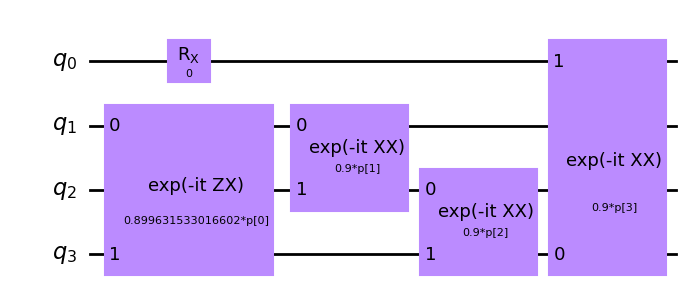

In [13]:
#optimized_operations='o0_ZX_13_0_0.89-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9'

#RESULTADO FINAL SOBRE DATASET TEST
print("The final cost is:", optimized_cost)
print('The final Kernel operations ', optimized_operations)
print('The final optimized C in SVM ', optimized_c)

circuit=optimized_kernel.get_qiskit_ansatz()
display(circuit.draw(output="mpl", fold=-1))

# Cargar las matrices desde los archivos .npy
K_train_cargada = np.load(f'kernels/kernel_medico/{groups}/{grupo}/K_train_{"-".join(optimized_operations)}.npy')


Para terminar vamos a evaluar con los datos de test las metricas de clasificación que se obtienen con el Kernel de entrenamiento optimo encontrado por el optimizador heurístico.

En este paso, calcularemos y almacenaremos la matriz de Gram de los datos de test de este kernel.

In [14]:
# optimized_operations='o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9'
# optimized_c=100
# optimized_kernel, operations=initial_kernel()
# K_train_cargada=K_train= np.load(f'kernels/kernel_medico/{groups}/{grupo}/K_train_{optimized_operations}.npy')

# Instantiate a machine learning model
model = SVC(kernel='precomputed',C=optimized_c)
model.fit(K_train_cargada, y)

# Predict the labels for the test data
start = time.time()
K_test = optimized_kernel.build_kernel(X_test, X)
y_test_pred = model.predict(K_test)
end = time.time()
print('prediction - time elapsed', (end-start)/60 ,'min')

# Guardar la matrices en archivos .npy
np.save(f'kernels/kernel_medico/{groups}/{grupo}/K_test_{"-".join(optimized_operations)}.npy', K_test)
#Cargar K_test
K_test_cargada = np.load(f'kernels/kernel_medico/{groups}/{grupo}/K_test_{"-".join(optimized_operations)}.npy')

prediction - time elapsed 17.2048046429952 min


Visualizamos las matrices de Gram del kernel optimo de entrenamiento y test

Training Gram matrix [[1.         0.98539342 0.95588251 ... 0.305911   0.35247292 0.29331533]
 [0.98539342 1.         0.96146486 ... 0.30271457 0.366951   0.29641252]
 [0.95588251 0.96146486 1.         ... 0.34361115 0.36779622 0.33443641]
 ...
 [0.305911   0.30271457 0.34361115 ... 1.         0.737306   0.98968361]
 [0.35247292 0.366951   0.36779622 ... 0.737306   1.         0.72215295]
 [0.29331533 0.29641252 0.33443641 ... 0.98968361 0.72215295 1.        ]]
Testing Gram matrix  [[0.84410668 0.80786728 0.77042508 ... 0.30645328 0.24283278 0.30108833]
 [0.9839813  0.99234902 0.95535452 ... 0.2869766  0.37185071 0.27697111]
 [0.32830172 0.35416255 0.34065561 ... 0.77655503 0.88079362 0.80905045]
 ...
 [0.34438039 0.35096287 0.37369387 ... 0.95788497 0.87909858 0.95762667]
 [0.91936745 0.90593863 0.93568482 ... 0.36601868 0.3124682  0.36053253]
 [0.96928599 0.97541158 0.98950518 ... 0.34639527 0.3580946  0.3403519 ]]


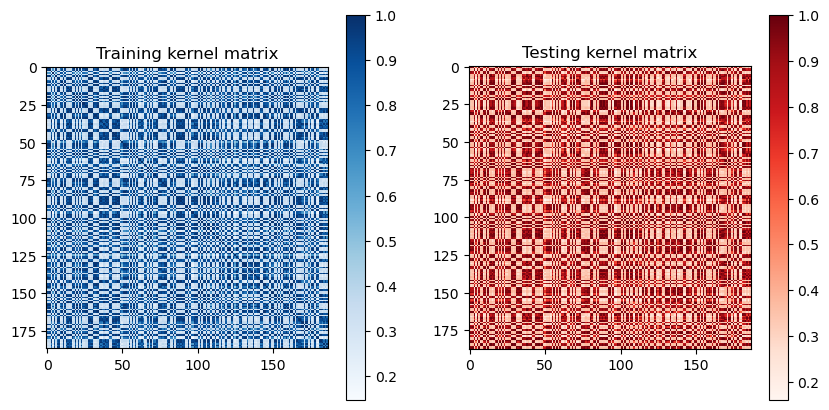

In [15]:
#Las matrices de Gram para los conjuntos de datos de train y test
K_train=K_train_cargada
K_test=K_test_cargada
print('Training Gram matrix', K_train)
print('Testing Gram matrix ', K_test)

#visualizacion como imagenes de los valores de las matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im=axs[0].imshow(
    np.asmatrix(K_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
fig.colorbar(im)

im=axs[1].imshow(np.asmatrix(K_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

fig.colorbar(im)
plt.show()

Y representamos las metricas de clasificación sobre el conjunto de datos de test

Total Accuracy (for all classes): 0.4627659574468085
              precision    recall  f1-score   support

           0       0.61      0.54      0.58        70
           1       0.25      0.13      0.17        60
           2       0.44      0.71      0.54        58

    accuracy                           0.46       188
   macro avg       0.43      0.46      0.43       188
weighted avg       0.44      0.46      0.44       188



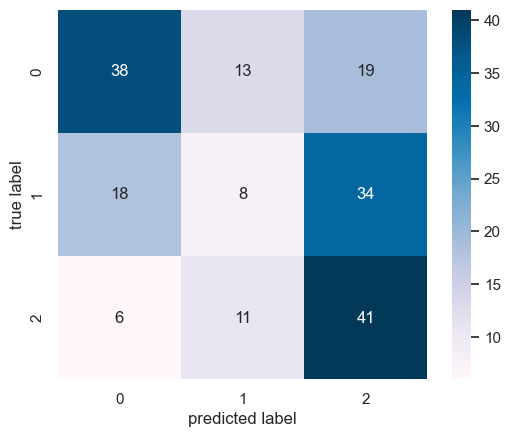

In [16]:
# Calculate the accuracy
accuracy = np.sum(y_test == y_test_pred) / len(y_test)
print("Total Accuracy (for all classes):", accuracy)

#confussion matrix metrics
print(metrics.classification_report(y_test,y_test_pred))

#confusion matrix plot
sn.set()
mat = confusion_matrix(y_test,y_test_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');

## Metodo propio de evaluación del Kernel

Las librerías **QuASK** vienen provistas de una serie de clases de evaluadores que nos ayudan en la búsqueda del Kernel cuántico y también permiten desarrollar un evaluador ad-hoc por parte del usuario.

En este trabajo se desarrolla un evaluador que calcula las métricas de clasificacion que se obtendrían con el Kernel cuantico que estamos evaluando cuando se hace una prediccion sobre los datos de entrenamiento. De manera que no vamos a evaluar características del circuito cuantico, no del mapeo de características como los evaluadores propuestos en QuASK, sino que vamos a evaluar el propio desempeño predictivo del Kernel.

Describimos como funciona este evaluador. De entrada evaluador toma como argumentos de entrada el kernel a evaluar, la matriz de Gram del kernel, los datos y etiquetas de entrenamiento. Si se da la matriz de Gram, no será necesario recalcular el kernel y este no se llega a utilizar. El evaluador calcula una métrica de clasificación SVC para los datos de entrenamiento, que en este caso es la suma de los `F1 scoring` de todas las clases (variable `f_all`). Esta métrica puede tomar un valor máximo de 300, en el caso de que los scores de todas las clases sean máximos, por lo que el coste de evaluacion que devuelve este evaluador es 300 - `f_all`, que es el valor que se devuelve como coste del algoritmo (el parametro a minimizar para el kernel optimo).

El evaluador hace algo más, realiza un ajuste fino del parámetro de regularización `C` del modelo de clasificación SVC, de forma que entrena diferentes modelos de clasificacion SVC con diferentes valores de esta constante y va haciendo seguimiento de la metrica de clasificacion que se obtienen para los datos de entrenamiento en cada modelo. Cuando esta metrica mejora para algunvalor de `C` se almacena este como el optimo. Este valor optimo de `C` y el valor minimo de coste son los valores que el evaluador devuelve como resultado.

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from quask.core import Kernel
from quask.evaluator import KernelEvaluator


class myEvaluator(KernelEvaluator):
    """
    Calculate the model fit, print confusion matrix and associate cost to f1 of class 2 
    """

    def evaluate(self, kernel: Kernel, K: np.ndarray, X: np.ndarray, y: np.ndarray):
        """
        Evaluate the current kernel and return the corresponding cost. Lower cost values corresponds to better solutions
        
        :param kernel: kernel object
        :param K: optional kernel matrix \kappa(X, X)
        :param X: datapoints
        :param y: labels
        :return: cost of the kernel, the lower the better
        """
        if K is None:
            K = kernel.build_kernel(X, X)

        return self.calculate_model_cost(K, X, y)

    @staticmethod
    def calculate_model_cost(k, X, y):
        """
        Calculate the model cost f1 class 2

        :param k: Kernel gram matrix
        :param X: training data
        :param y: Labels
        :return: model cost of the given kernel
        """
        cs = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
              10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
        #Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.
        #Meanwhile, larger C values will take more time to train

        #EVALUATION ON TRAINING DATA
        #X_eval= X.copy()
        y_eval= y.copy()

        maxmean = 0
        final_c=1 #default value
        for c in cs:
            # Instantiate a machine learning model
            model = SVC(kernel='precomputed', C=c)
            model.fit(k, y)
            y_eval_pred = model.predict(k)
            #confussion matrix metrics
            m=metrics.classification_report(y_eval,y_eval_pred)
            f1_c0=100*float(m.split('\n')[2].split('      ')[4]) #f1-score accuracy class 0
            f1_c1=100*float(m.split('\n')[3].split('      ')[4]) #f1-score accuracy class 1
            f1_c2=100*float(m.split('\n')[4].split('      ')[4]) #f1-score accuracy class 2
            f1_all=100*float(m.split('\n')[6].split('      ')[4]) #f1-score accuracy all classes
            not_cero= (f1_c0 !=0) and (f1_c1 !=0) and (f1_c2 !=0)
            #print(' f1-score accuracy '+str(f1_c0+f1_c2)+ ' all '+str(f1_c0+f1_c1+f1_c2)+'- c ',c,'--------------------------')

            if maxmean<(f1_c0+f1_c1+f1_c2) and not_cero:   
                maxmean=f1_c0+f1_c1+f1_c2
                final_c=c
                print('Eval on training data')
                print(' f1-score accuracy '+str(maxmean)+ ' - c ',c,'--------------------------')
                print(m)

        return 300-maxmean, final_c
